# Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     StratifiedKFold, GridSearchCV)
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             classification_report)

np.random.seed(23)

In [2]:
df = pd.read_csv('Data/data_cleaned.csv')

In [3]:
df.head()

,action_type,combined_shot_type,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent
0,Jump Shot,Jump Shot,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR
1,Jump Shot,Jump Shot,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR
3,Driving Dunk Shot,Dunk,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR


# Dummifying Features & Concatenating Dataframe
---

In [4]:
df.columns.to_list()

['action_type',
 'combined_shot_type',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'game_date',
 'matchup',
 'opponent']

In [5]:
df['year'] = [x[:4] for x in df.game_date]

In [6]:
features = ['combined_shot_type', 'minutes_remaining', 
            'period', 'shot_type', 'year', 'opponent']

# snake_casing subgroups for features 
for feature in features:
    if df[feature].dtypes == object:
        df[feature] = [x.replace(' ', '_') for x in df[feature]]
        
df_dum = pd.get_dummies(df[features], drop_first=True)

df_final = pd.concat([df_dum, 
                      df[['playoffs', 
                          'shot_distance', 
                          'shot_made_flag']]], 
                     axis=1)

In [7]:
df_final.head()

,minutes_remaining,period,combined_shot_type_Dunk,combined_shot_type_Hook_Shot,combined_shot_type_Jump_Shot,combined_shot_type_Layup,combined_shot_type_Tip_Shot,shot_type_3PT_Field_Goal,year_1997,year_1998,...,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,playoffs,shot_distance,shot_made_flag
0,10,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,0.0
1,7,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,1.0
2,6,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22,0.0
3,6,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
4,9,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,0.0


## Train Test Split

In [8]:
X = df_final.drop('shot_made_flag', axis=1)
y = df_final.shot_made_flag

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size = 0.20,
                                                   random_state = 23)

## Standard Scale

In [10]:
# initialize
ss = StandardScaler()

# fit on Train
X_train_ss = pd.DataFrame(ss.fit_transform(X_train), 
                          columns=X_train.columns, 
                          index=X_train.index)

# transform test
X_test_ss = pd.DataFrame(ss.transform(X_test), 
                         columns=X_test.columns, 
                         index=X_test.index)

## SelectKBest

In [11]:
# Create and fit selector
selector = SelectKBest(k=20)
selector.fit(X_train_ss, y_train)

SelectKBest(k=20)

In [12]:
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)

In [13]:
X_train = X_train_ss.iloc[:,cols]
X_test = X_test_ss.iloc[:,cols]

In [14]:
# Selected Columns
X_train.columns.tolist()

['minutes_remaining',
 'period',
 'combined_shot_type_Dunk',
 'combined_shot_type_Jump_Shot',
 'combined_shot_type_Layup',
 'shot_type_3PT_Field_Goal',
 'year_2000',
 'year_2001',
 'year_2004',
 'year_2008',
 'year_2009',
 'year_2014',
 'year_2015',
 'year_2016',
 'opponent_BOS',
 'opponent_IND',
 'opponent_MIL',
 'opponent_NYK',
 'opponent_PHX',
 'shot_distance']

# Modeling
---

## Calculate the baseline

In [15]:
baseline = round(df_final['shot_made_flag'].value_counts(normalize=True)[0] * 100)
print(f'Baseline score: {baseline}%')

Baseline score: 55%


## Let's create a function to print out cross val score

In [16]:
def model_scores(cv_scores, model, X, y, model_name):  
    print(f'Score from {model_name}: {model.score(X, y):.4f}')
    print(f'Min and Max scores are: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]')
    print(f'Confidence interval is : {cv_scores.mean():.4f} \u00B1 {2*cv_scores.std():.4f}')

## Now let's create a Random Forest Model

In [17]:
rf = RandomForestClassifier(n_jobs=-1, random_state=23, n_estimators=20, class_weight='balanced', max_depth=10)
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=20,
                       n_jobs=-1, random_state=23)

In [18]:
X = df_final.drop('shot_made_flag', axis=1)
y = df_final.shot_made_flag

In [19]:
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

scores = cross_val_score(rf, X, y, cv=cv)

model_scores(scores, rf, X_test, y_test, 'random forest')

Score from random forest: 0.6070
Min and Max scores are: [0.5965, 0.6261]
Confidence interval is : 0.6101 ± 0.0163


### For our Random Forests model our accuracy was 60.70% which is 5.7% better than our baseline of 55%. Our mean cross val score for our model is 61.01% with a confidence interval of ± 1.63% which is a small interval showing we have low variance.

## Now let's look at the feature importance of our Random Forest model to identify the features that are most relevant.

In [20]:
df_feature_importance = pd.DataFrame({'feature':X_train.columns,
                                      'importance':rf.feature_importances_})
df_feature_importance.sort_values('importance', ascending=False).head()

,feature,importance
19,shot_distance,0.303423
2,combined_shot_type_Dunk,0.168515
3,combined_shot_type_Jump_Shot,0.106335
0,minutes_remaining,0.102162
4,combined_shot_type_Layup,0.069738


## According to our Random Forest model the above 5 features have the best predictive power (level of importance).

In [21]:
df_final.groupby('shot_made_flag').describe()['shot_distance']

,count,mean,std,min,25%,50%,75%,max
shot_made_flag,,,,,,,,
0.0,14232.0,15.127600,9.193606,0.0,8.0,16.0,22.0,79.0
1.0,11465.0,11.383428,9.213679,0.0,0.0,12.0,19.0,43.0


### Top 2 features
 - shot_distance: We can see that the average shot distance for made shots is 11.38 feet and for misses is 15.12 feet. We want shots to be closer to 11 feet for better odds of making it.
 - combined_shot_type_Dunk: We want to make sure dunks are emphasized since our model predicted this as being important and leading to more successful shots made.

# Logistic Regression Model

In [22]:
logreg_params = {'penalty': ['l1', 'l2'], 
                 'solver': ['liblinear', 'saga'],
                }

logreg_gridsearch = GridSearchCV(LogisticRegression(), 
                                 logreg_params, 
                                 cv=5, 
                                 n_jobs=-1)

logreg_gridsearch.fit(X_train, y_train.values.ravel())

print(logreg_gridsearch.best_estimator_)
print(logreg_gridsearch.best_params_)

print('\nBaseline: 55%')

print('\nBest Score:', round(logreg_gridsearch.best_score_, 4))
print('Test Score:', round(logreg_gridsearch.score(X_test, y_test.values.ravel()), 4))

LogisticRegression(penalty='l1', solver='saga')
{'penalty': 'l1', 'solver': 'saga'}

Baseline: 55%

Best Score: 0.6133
Test Score: 0.6111


# Cross Val

In [23]:
logreg = LogisticRegression(max_iter=50000, 
                            penalty='l1', 
                            random_state=73, 
                            solver='liblinear')

logreg.fit(X_train, y_train.values.ravel())

train_scores = cross_val_score(logreg, X_train, y_train.values.ravel())
test_scores = cross_val_score(logreg, X_test, y_test.values.ravel())

print('Baseline: 55%\n')

print('Train scores:', train_scores)
print('Mean:', round(train_scores.mean(), 3))
print('Stdev:', round(2 * train_scores.std(), 3), '\n')

print('Test scores:', test_scores)
print('Mean:', round(test_scores.mean(), 3))
print('Stdev:', round(2 * test_scores.std(), 3), '\n')

Baseline: 55%

Train scores: [0.60797665 0.61527237 0.61177329 0.61444904 0.61663829]
Mean: 0.613
Stdev: 0.006 

Test scores: [0.60700389 0.60311284 0.61575875 0.60019455 0.60505837]
Mean: 0.606
Stdev: 0.011 



# Coefficient Interpretation

In [24]:
logreg_coefs_0 = pd.DataFrame(list(zip(X_train.columns, np.expm1(logreg.coef_[0]))), 
                           columns=['features', 'coef'])

logreg_coefs_0['abs'] = abs(logreg_coefs_0['coef'])

logreg_coefs_0.sort_values('abs', ascending=False).head(10)

,features,coef,abs
2,combined_shot_type_Dunk,0.598433,0.598433
3,combined_shot_type_Jump_Shot,-0.156243,0.156243
19,shot_distance,-0.130305,0.130305
5,shot_type_3PT_Field_Goal,-0.060304,0.060304
1,period,-0.053639,0.053639
0,minutes_remaining,0.044301,0.044301
10,year_2009,0.032707,0.032707
16,opponent_MIL,-0.030585,0.030585
8,year_2004,-0.029788,0.029788
17,opponent_NYK,0.027477,0.027477


# Metrics

              precision    recall  f1-score   support

      Missed       0.61      0.84      0.70      2833
        Made       0.63      0.33      0.43      2307

    accuracy                           0.61      5140
   macro avg       0.62      0.59      0.57      5140
weighted avg       0.62      0.61      0.58      5140



''

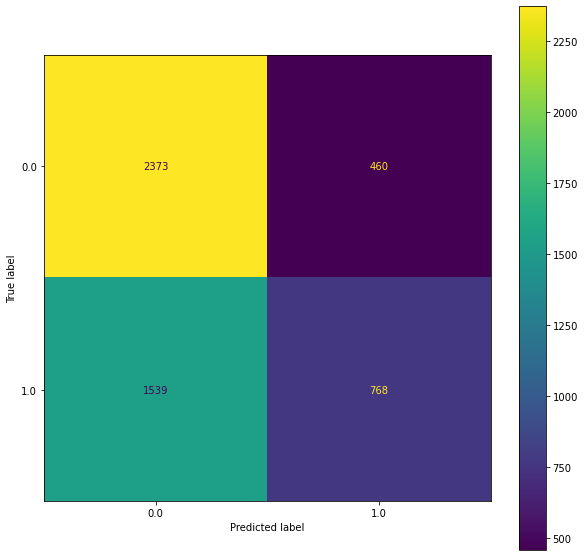

In [25]:
conmat = np.array(confusion_matrix(y_test, 
                                   logreg.predict(X_test), 
                                   labels=[0, 1]))

print(classification_report(y_test,
                            logreg.predict(X_test), 
                            target_names=['Missed', 'Made']))

matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                                        display_labels=logreg.classes_)
matrix_display.plot()

figure = plt.gcf()
figure.set_size_inches(10, 10)
;

## Analysis

- The Logistic Regression model was overall 61% accurate in predicting the Target Class - "Shot Made"
- This is 6% better than the baseline model of 55% (majority class: "Shit Missed"
- The features with the largest coefficients 
    - `combined_shot_type_Dunk`
    - `combined_shot_type_Jump_Shot`
    - `shot_distance`
    - `shot_type_3PT_Field_Goal`
    - `minutes_remaining`
- This Logistic Regression model had the same accuracy in predicting the target class as the Random Forest model. Both models had similar "important features". 

## Conclusions
---
We are going to use our Logistic Regression model over our Random Forest model. Even though both models scored the same our Logisitc Regression model provides more interpretable coefficients to better identify which characteristics lead to whether a shot is made or not. Due to time constraints we did not run a GridSearch on our Random Forests model. Provided we have more time that would be an important next step to help better improve our model's score. `combined_shot_type_Dunk` was one characteristic that showed up with the highest coefficient in the Logist Regression model and as the 2nd most important feature in the Random Forests model. To better improve chances of making a shot dunk the ball!!!!